# 🎤 Gender Classification from Speech using Machine Learning

This notebook demonstrates how to build a machine learning pipeline for **speech classification** — specifically, classifying whether a speaker is male or female based on their voice recordings.

We'll walk through the following steps:

---

## 📌 Objectives

- Preprocess audio data to improve quality and consistency.
- Extract relevant features from speech signals.
- Train a machine learning model (Logistic Regression) for classification.
- Evaluate model performance using accuracy and classification metrics.

---

## 🛠️ Techniques Used

### 🔉 Audio Preprocessing
- **Trimming**: Remove silence from the beginning and end of the audio.
- **Normalization**: Ensure audio levels are consistent across files.
- **Resampling**: Convert all files to a consistent sampling rate.
- **Padding/Truncating**: Ensure all inputs have the same length.

### 📊 Feature Extraction
We extract powerful features that capture characteristics of the speaker’s voice:
- **MFCCs (Mel-Frequency Cepstral Coefficients)**: Capture timbral and phonetic content.
- **Spectral Centroid**: Measures the "center of mass" of frequencies.
- **Spectral Rolloff**: Frequency below which a set percentage (e.g., 85%) of the energy is contained.
- **Zero-Crossing Rate**: Counts how often the signal changes sign — higher for noisy or unvoiced sounds.
- **RMS Energy**: Captures the loudness of the signal.

---

## 🧠 Model
We use a **Logistic Regression** model to classify audio based on extracted features. The model is trained on labeled examples of male and female voices.

---

## 📈 Evaluation
The final model is evaluated using:
- **Accuracy**
- **Precision, Recall, F1-Score**
- **Confusion Matrix**

---

Let's get started!


In [14]:
!pip install noisereduce

In [70]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


# Importing Libraries

In [71]:
# Standard Library
import os
from collections import Counter

# Numerical and Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Audio Processing
import librosa
import librosa.effects
import noisereduce as nr
import IPython.display as ipd

# Machine Learning Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Model Utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.decomposition import PCA

# Experimenting on a Sample

let's take a sample and use it in experimenting and visualizing 

In [16]:
sample = '/kaggle/input/gender-recognition-by-voiceoriginal/data/female/arctic_b0454.wav'

# Audio Processing

## 1. Load Audio File

In [17]:
ipd.Audio(sample)

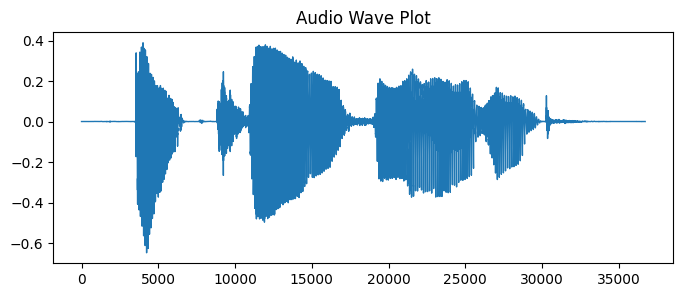

In [18]:
x, sr = librosa.load(sample)

pd.Series(x).plot(figsize=(8, 3), lw=1)
plt.title('Audio Wave Plot')
plt.show()

## 2. ✂️ Trim Silence
Removes unnecessary silence from the beginning and end of the audio. This helps eliminate parts of the audio that contain no useful information.

We use `librosa.effects.trim()` function with a parameter `top_db` which stands for "how many decibels below the peak" should be considered silence.

"Decibels" is a logarithmic unit used to measure sound level.

* Lower `top_db` (e.g., `20`) → stricter silence removal (only trims very quiet parts).
* Higher `top_db` (e.g., `60`) → more aggressive (trims even moderately quiet parts).

We will choose `35` which is somewhat in the middle

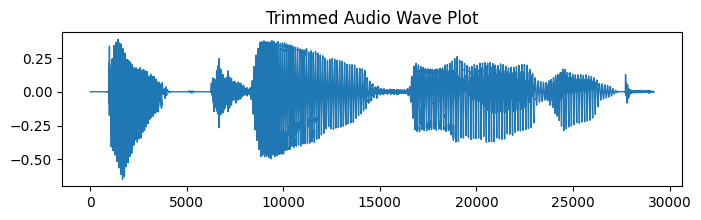

In [19]:
trimmed_x, index = librosa.effects.trim(x, top_db=35)
pd.Series(trimmed_x).plot(figsize=(8, 2), lw=1)
plt.title('Trimmed Audio Wave Plot')
plt.show()

## 3. 🧼 Noise Reduction

Reduces background noise such as hums, hisses, or ambient sounds using filters or noise reduction algorithms.

* High-pass filters remove low-frequency noise.
* `noisereduce` library can automatically detect and reduce noise.

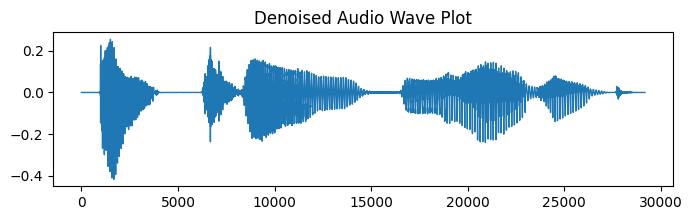

In [20]:
import noisereduce as nr

denoised_x = nr.reduce_noise(y=trimmed_x, sr=sr)

pd.Series(denoised_x).plot(figsize=(8, 2), lw=1)
plt.title('Denoised Audio Wave Plot')
plt.show()

## 4. 📈 Normalization

Ensures all audio signals are on the same volume scale by scaling the waveform so its peak is consistent across samples.

In [21]:
normalized_x = librosa.util.normalize(denoised_x)

## 5. ⏱️ Resampling (Optional)

Resamples all audio to the same sampling rate (e.g. 16,000 Hz), which ensures uniformity across the dataset.

Sample rate: how many samples per second are used to represent the audio.

In [22]:
resampled_x = librosa.resample(x, orig_sr=sr, target_sr=16000)

## 6. 🧱 Padding or Truncating

Length of our audio sample (x): 36714
Length of our resized sample: 30000


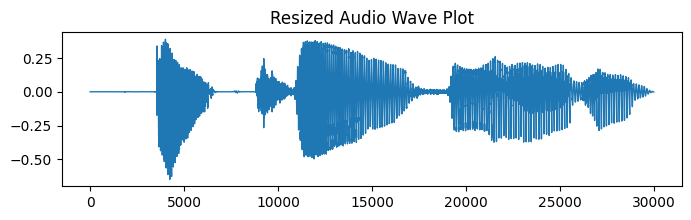

In [23]:
desired_length = 30000

print("Length of our audio sample (x):", len(x))
resized_x = x

if len(x) < desired_length:
    resized_x = np.pad(x, (0, desired_length - len(x)))
else:
    resized_x = x[:desired_length]

print('Length of our resized sample:', len(resized_x))
pd.Series(resized_x).plot(figsize=(8, 2), lw=1)
plt.title('Resized Audio Wave Plot')
plt.show()

Let's look the audio wave at a more zoomed level

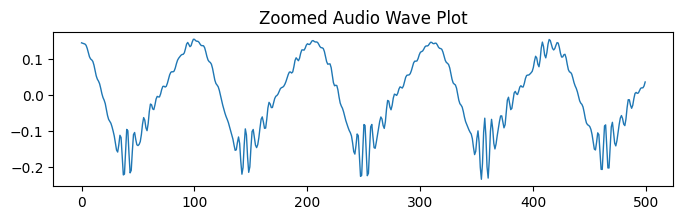

In [24]:
pd.Series(denoised_x[9000:9500]).plot(figsize=(8, 2), lw=1)
plt.title('Zoomed Audio Wave Plot')
plt.show()

# Feature Extraction

Now let's look at various feature extraction techniques

## 1. 📊 Spectrogram

Shows how the frequencies of the audio signal change over time.

* **X-axis**: time
* **Y-axis**: frequency
* **Color**: amplitude (loudness) of each frequency at that moment

In [25]:
transformed_x = librosa.stft(trimmed_x)
db = librosa.amplitude_to_db(abs(transformed_x))
db.shape

(1025, 58)

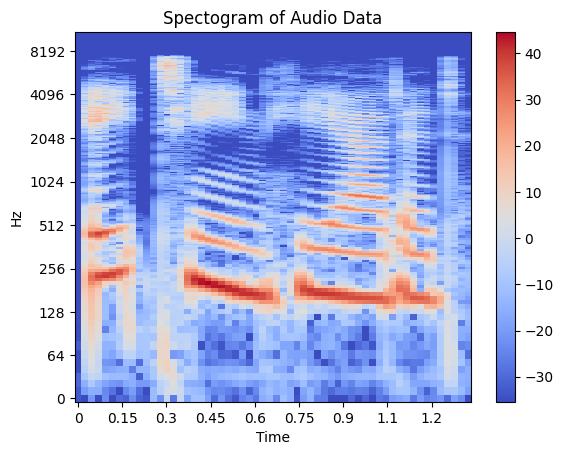

In [26]:
image = librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(image)
plt.title('Spectogram of Audio Data')
plt.show()

## 2. 🎵 Mel Spectogram

Similar to a regular spectrogram, but the frequency axis is scaled to match how humans hear (the Mel scale).

It focuses more on low to mid frequencies, which are most important for speech and music.

In [27]:
S = librosa.feature.melspectrogram(y=x, sr=sr)

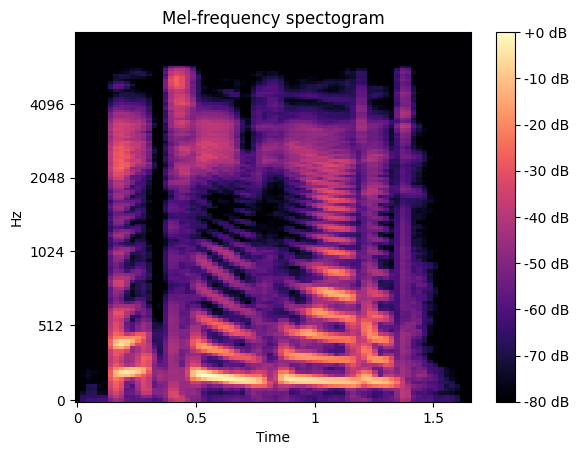

In [28]:
fig, ax = plt.subplots()
S_db = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectogram')
plt.show()

## 3. 🎯 Spectral Centroid

The Spectral Centroid tells us where the "center of mass" of the sound frequencies is — it shows us how "bright" or "dark" a sound is.

* If most energy is in high frequencies, the centroid is high → the sound is bright or sharp (like cymbals).
* If most energy is in low frequencies, the centroid is low → the sound is dull or bassy (like drums or male voices).

In [29]:
cent = librosa.feature.spectral_centroid(y=x, sr=sr)
frames = range(len(cent))
time = librosa.frames_to_time(frames)
S, phase = librosa.magphase(librosa.stft(y=x))
freqs, times, D = librosa.reassigned_spectrogram(x, fill_nan=True)

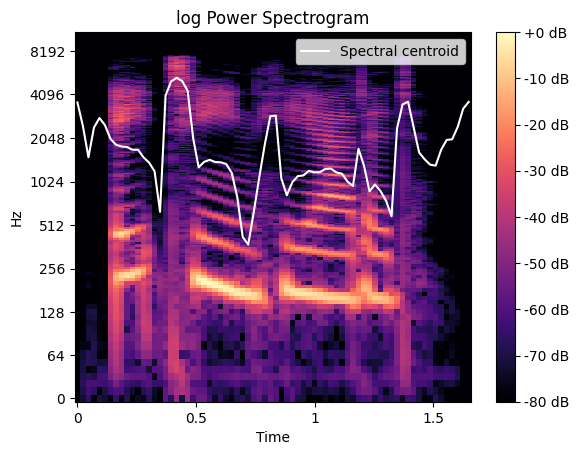

In [30]:
times = librosa.times_like(cent)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, cent.T, label='Spectral centroid', color='w')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.legend(loc='upper right')
ax.set(title='log Power Spectrogram')
plt.show()

## 4. ⚡ Zero Crossings (ZCR)

Counts how often the waveform changes sign (+ to - or - to +).

* High ZCR → Noisy, sharp, or high-pitched sounds
* Low ZCR → Smooth, low, bassy sounds

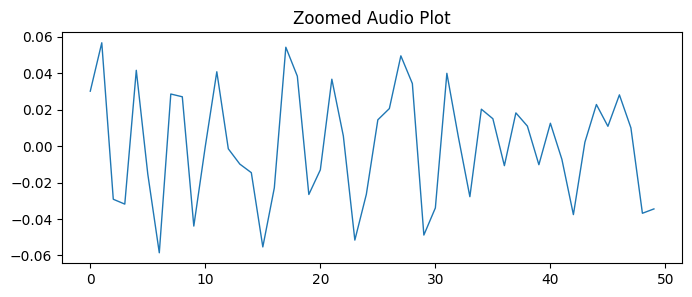

In [31]:
n0 = 10000
n1 = 10050
pd.Series(x[n0:n1]).plot(figsize = (8, 3), lw = 1)
plt.title("Zoomed Audio Plot")
plt.show()

In [32]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(zero_crossings.shape)
print("Number of Zero Crossings: ", sum(zero_crossings))

(50,)
Number of Zero Crossings:  23


## 5. 🌊 Spectral Rolloff

Tells us the frequency, where below this frequency (point) is 85% of the total energy (amplitude) in the sound.

#### Example:
🧔 Male Voice (Deep, Low-pitched)

* Most energy is in low frequencies.
* We might reach 85% of the energy by 2000 Hz.
* ✅ So the Spectral Rolloff is low.

👩 Female Voice (High-pitched)

* Energy is spread into higher frequencies.
* We may need to go up to 5000 Hz to reach 85% of the energy.
* ✅ So the Spectral Rolloff is higher.

In [33]:
rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr)[0]
print('Rolloff Shape:', rolloff.shape)

Rolloff Shape: (72,)


## 6. 🎼 MFCC (Mel-Frequency Cepstral Coefficients)
Captures the overall shape of the audio spectrum in a way that mimics human hearing. Commonly used in speech and music analysis.

MFCCs Shape: (20, 72)


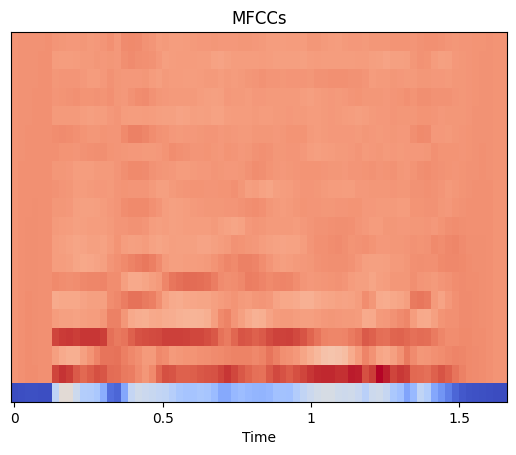

In [34]:
mfccs = librosa.feature.mfcc(y=x, sr=sr)
print("MFCCs Shape:", mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.title('MFCCs')
plt.show()

## 7. 📉 RMS (Root Mean Square Energy)

Captures the energy or loudness of the signal over time. Useful for understanding how powerful the sound is at each frame.

* High RMS values = loud parts (e.g., speech, music, noise).
* Low RMS values = silence or quiet parts.

It helps in voice activity detection, emotion recognition, and even trimming silent segments.

In [35]:
rms = librosa.feature.rms(y=x)[0]

# Get time axis for plotting
frames = range(len(rms))
t = librosa.frames_to_time(frames, sr=sr)

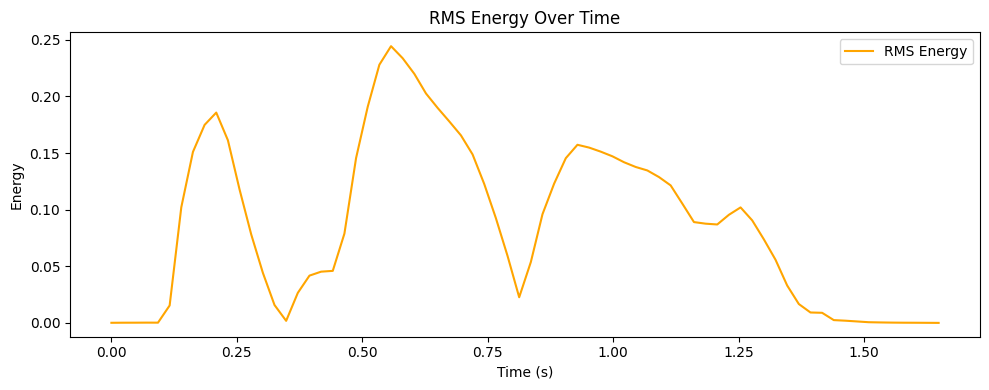

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(t, rms, label='RMS Energy', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('RMS Energy Over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Final Preprocessing on Data

### Audio Preprocessing

In [37]:
SAMPLE_RATE = 16000 # Standard rate for speech models
DURATION = 3 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [38]:
def PreprocessAudio(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        
        # trim silence
        y, _ = librosa.effects.trim(y)
        
        # reduce noise
        y = nr.reduce_noise(y=y, sr=sr)
        
        # normalize
        y = librosa.util.normalize(y)

        # padding/truncating
        if len(y) < SAMPLES_PER_TRACK:
            y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
        else:
            y = y[:SAMPLES_PER_TRACK]

        return y, sr
    except Exception as error:
        print(f"Failed to process '{file_path}': {error}")
        return None, None

### Feature Extraction

In [39]:
def ExtractAudioFeatures(file_path):
    audio_signal, sample_rate = PreprocessAudio(file_path)
    if audio_signal is None:
        return None

    n_fft = 2048  # means 2048 samples per window (~128ms if sr=16k)
    hop_length = 512  # means we move 512 samples forward for next window (~32ms)
    
    mfcc = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=13, hop_length=hop_length, n_fft=n_fft)
    mfcc_mean = np.mean(mfcc, axis=1)

    rolloff = librosa.feature.spectral_rolloff(y=audio_signal, sr=sample_rate, hop_length=hop_length, n_fft=n_fft)[0]
    rolloff_mean = np.mean(rolloff)

    zcr = librosa.feature.zero_crossing_rate(y=audio_signal, hop_length=hop_length)[0]
    zcr_mean = np.mean(zcr)

    centroid = librosa.feature.spectral_centroid(y=audio_signal, sr=sample_rate, hop_length=hop_length, n_fft=n_fft)[0]
    centroid_mean = np.mean(centroid)

    rms = librosa.feature.rms(y=audio_signal, hop_length=hop_length)[0]
    rms_mean = np.mean(rms)

    combined_features = np.hstack([
        mfcc_mean,
        rolloff_mean,
        zcr_mean,
        centroid_mean,
        rms_mean
    ])

    return combined_features

# Load Data

In [40]:
male_folder = '/kaggle/input/gender-recognition-by-voiceoriginal/data/male/'
female_folder = '/kaggle/input/gender-recognition-by-voiceoriginal/data/female'

In [41]:
data = []
labels = []

In [42]:
def process_male_file(file_path):
    features = ExtractAudioFeatures(file_path)
    if features is not None:
        return (features, 'male')
    return None

Since the two folders are large (`male_folder` contains 10.5k files), we will use parallel processing to speed up the process 

In [43]:
import concurrent.futures
from tqdm import tqdm

# get all file paths first
file_paths = [os.path.join(male_folder, f) for f in os.listdir(male_folder) if os.path.isfile(os.path.join(male_folder, f))]

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_male_file, file_paths), total=len(file_paths)))

for result in results:
    if result is not None:
        features, label = result
        data.append(features)
        labels.append(label)

100%|██████████| 10380/10380 [11:51<00:00, 14.59it/s]


In [44]:
def process_female_file(file_path):
    features = ExtractAudioFeatures(file_path)
    if features is not None:
        return (features, 'female')
    return None

In [45]:
file_paths = [os.path.join(female_folder, f) for f in os.listdir(female_folder) if os.path.isfile(os.path.join(female_folder, f))]

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_female_file, file_paths), total=len(file_paths)))

for result in results:
    if result is not None:
        features, label = result
        data.append(features)
        labels.append(label)

100%|██████████| 5768/5768 [06:29<00:00, 14.80it/s]


Now that we loaded our two folders, we can create our dataframe

In [47]:
df = pd.DataFrame(data)
df['gender'] = labels

In [48]:
feature_columns = ([f"mfcc_{i+1}" for i in range(13)] +["spectral_rolloff", "zero_crossing_rate", "spectral_centroid", "rms"])

df.columns = feature_columns + ['gender']

df = df.sample(frac=1).reset_index(drop=True)

df.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,spectral_rolloff,zero_crossing_rate,spectral_centroid,rms,gender
0,-306.556854,63.740196,17.129068,56.490608,13.971331,-16.682440,-1.655756,-5.021615,-21.374260,3.155300,-15.511492,-0.321851,-5.319719,3046.708777,0.155424,1808.714323,0.093570,male
1,-316.968292,55.952721,8.860790,18.137939,-8.627241,3.765638,-1.761843,-2.685677,-5.835275,-4.607826,-9.487219,-6.030136,-8.389662,3241.938165,0.223352,2305.759478,0.124762,female
2,-316.019897,50.678291,5.970245,47.330002,-20.300657,-6.136650,-16.930189,-19.175360,-17.041531,-12.432129,-6.822375,-10.143465,-4.536298,3468.001995,0.203416,2050.113406,0.116113,female
3,-310.586151,70.035995,3.907877,27.379641,-11.433548,-10.242325,-16.835508,-6.324730,-8.531161,-10.041706,-11.247950,-3.630981,-9.948803,2762.466755,0.134360,1511.924060,0.122222,female
4,-307.293915,74.038124,-0.927473,27.329556,-1.211772,-7.143049,-0.017714,-12.875146,-19.303461,6.188330,-7.183994,-2.293155,-5.797905,3234.375000,0.225825,2066.561506,0.083586,male


# EDA & Preprocessing

Now let's explore our constructed data

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16148 entries, 0 to 16147
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mfcc_1              16148 non-null  float64
 1   mfcc_2              16148 non-null  float64
 2   mfcc_3              16148 non-null  float64
 3   mfcc_4              16148 non-null  float64
 4   mfcc_5              16148 non-null  float64
 5   mfcc_6              16148 non-null  float64
 6   mfcc_7              16148 non-null  float64
 7   mfcc_8              16148 non-null  float64
 8   mfcc_9              16148 non-null  float64
 9   mfcc_10             16148 non-null  float64
 10  mfcc_11             16148 non-null  float64
 11  mfcc_12             16148 non-null  float64
 12  mfcc_13             16148 non-null  float64
 13  spectral_rolloff    16148 non-null  float64
 14  zero_crossing_rate  16148 non-null  float64
 15  spectral_centroid   16148 non-null  float64
 16  rms 

In [50]:
print("Data Shape:", df.shape)

Data Shape: (16148, 18)


In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mfcc_1,16148.0,-348.856362,44.497592,-550.382996,-375.704430,-343.531509,-317.620285,-235.896652
mfcc_2,16148.0,66.584201,20.926047,3.786150,51.536495,66.908211,81.092896,136.088623
mfcc_3,16148.0,10.520885,11.581218,-34.225639,2.545624,10.114014,18.022188,62.863789
mfcc_4,16148.0,34.494658,12.056346,-9.862965,25.880511,33.940645,42.441426,82.142815
mfcc_5,16148.0,-3.699868,11.353135,-46.143997,-11.774082,-3.795328,4.894171,33.999531
mfcc_6,16148.0,-1.586544,6.739415,-34.779926,-5.948017,-1.484674,2.835849,23.874369
mfcc_7,16148.0,-9.354207,8.441989,-40.559963,-15.118914,-9.343369,-3.610890,16.739544
mfcc_8,16148.0,-11.465190,7.842642,-42.358738,-16.054170,-10.741304,-5.904916,14.428802
mfcc_9,16148.0,-9.169787,6.231532,-33.249695,-13.297268,-8.425094,-4.583569,14.029229
mfcc_10,16148.0,-4.982229,5.721631,-27.313843,-8.826237,-4.831123,-0.963366,16.656683


## Null Values

In [52]:
df.isna().sum()

mfcc_1                0
mfcc_2                0
mfcc_3                0
mfcc_4                0
mfcc_5                0
mfcc_6                0
mfcc_7                0
mfcc_8                0
mfcc_9                0
mfcc_10               0
mfcc_11               0
mfcc_12               0
mfcc_13               0
spectral_rolloff      0
zero_crossing_rate    0
spectral_centroid     0
rms                   0
gender                0
dtype: int64

## Exploring Duplicates

In [53]:
print("Number of Duplicates:", df.duplicated().sum())
print(f"Percentage of Duplicates: {df.duplicated().sum() / len(df) * 100:.2f}%")

Number of Duplicates: 1078
Percentage of Duplicates: 6.68%


In [54]:
df = df.drop_duplicates()
print("Dropped Duplicates")
print(f"Percentage of Duplicates: {df.duplicated().sum() / len(df) * 100:.2f}%")
print("Data Shape:", df.shape)

Dropped Duplicates
Percentage of Duplicates: 0.00%
Data Shape: (15070, 18)


## Examining Class Imbalance

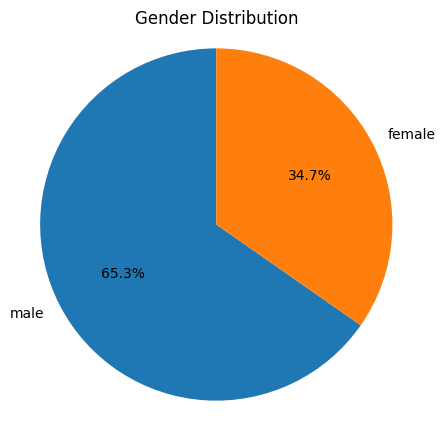

In [55]:
gender_counts = df['gender'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

We see here that we have a class imbalance in our target variable

To resolve this issue, we will assign weights to each of them in training phase

### Data Distribution

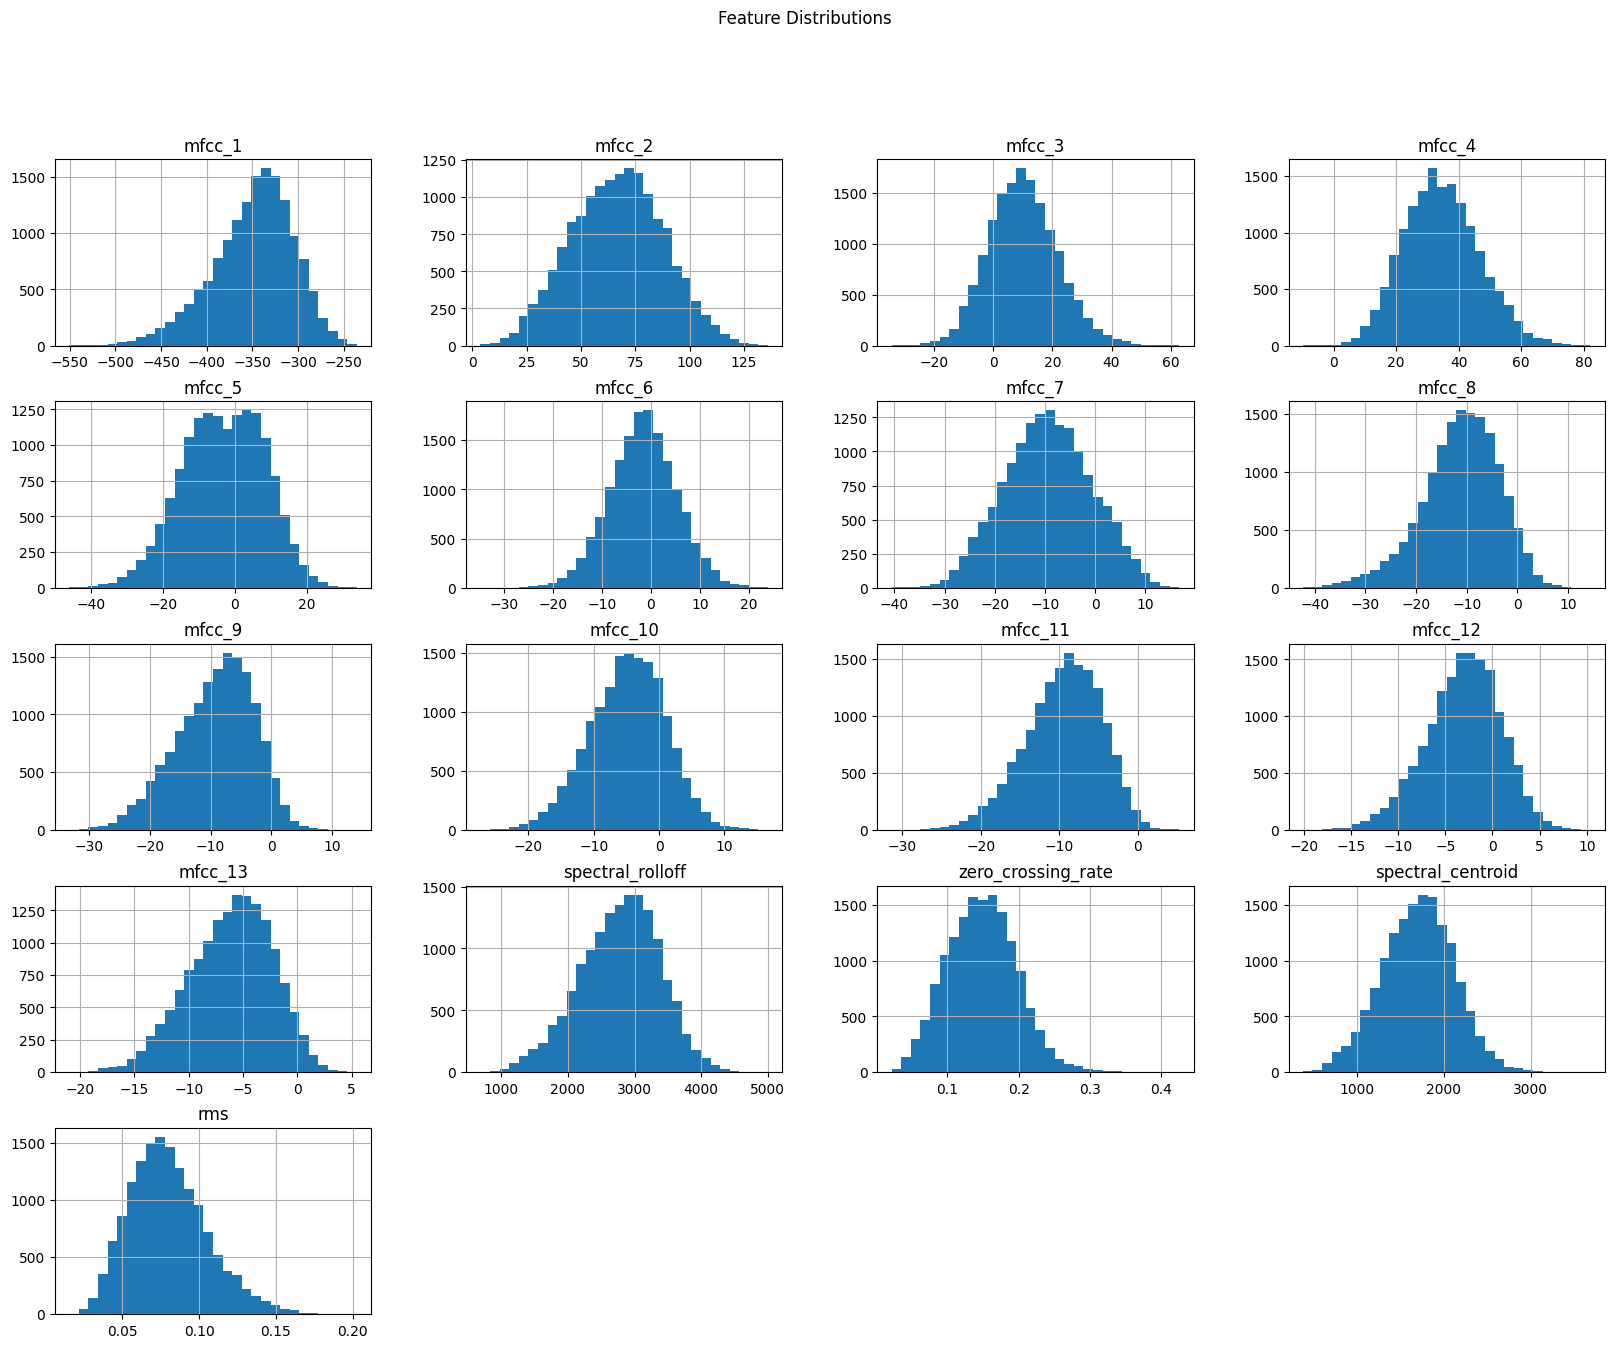

In [56]:
feature_columns = df.columns[:-1]
df[feature_columns].hist(bins=30, figsize=(20, 15))
plt.suptitle('Feature Distributions')
plt.show()

## Handling Outliers

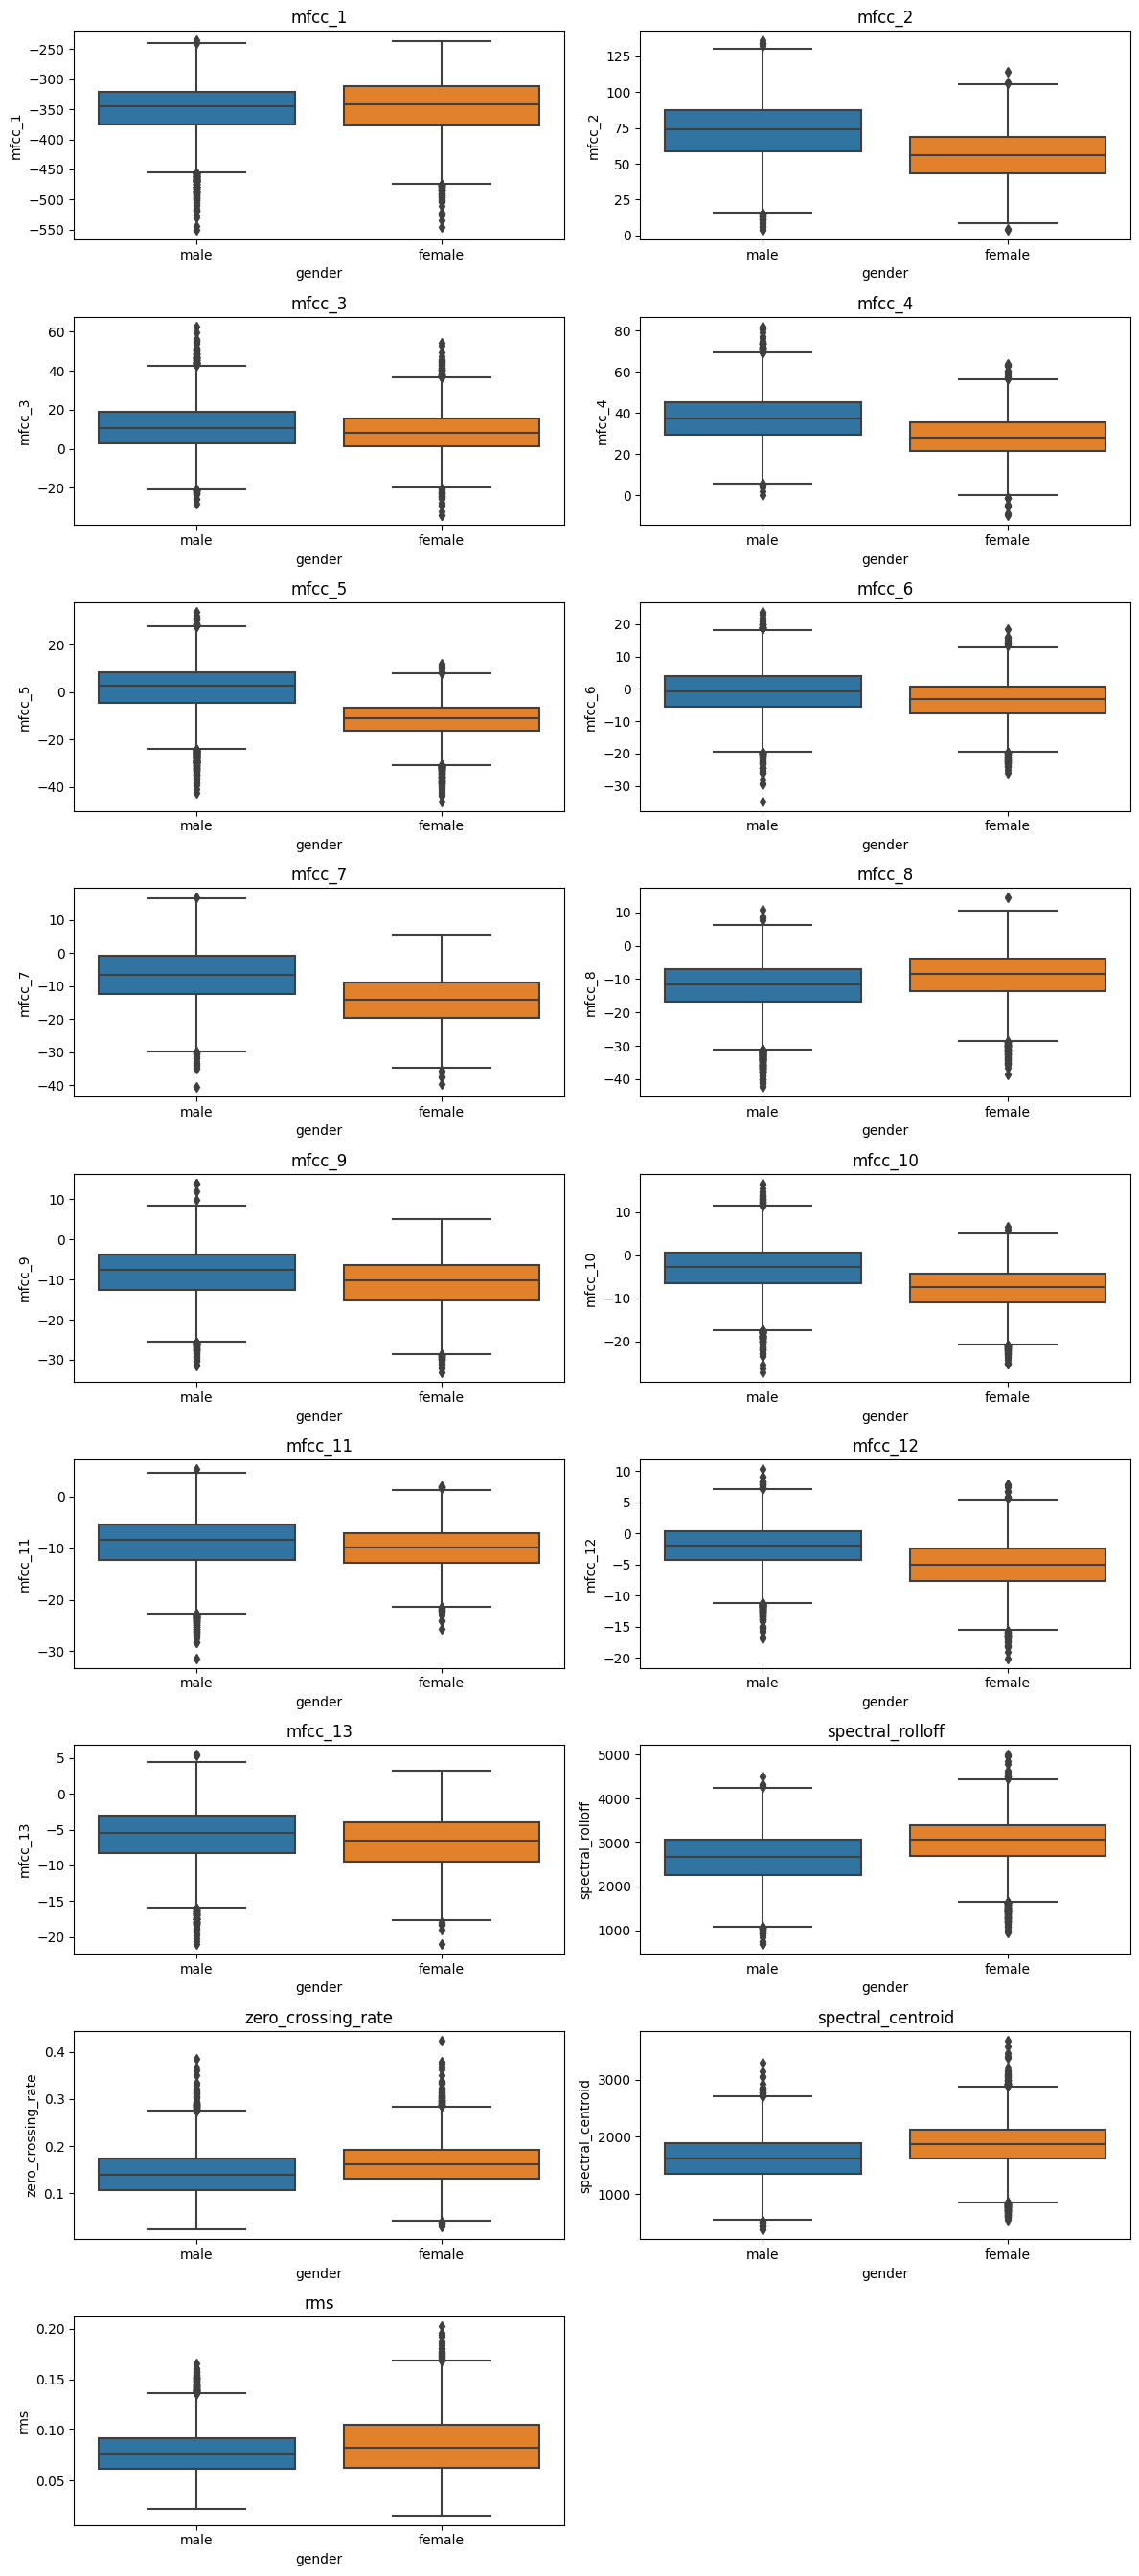

In [57]:
n = len(feature_columns)

rows = (n + 1) // 2
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i, col in enumerate(feature_columns):
    sns.boxplot(x='gender', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col}')

# Hide any unused plots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [59]:
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df[numerical_columns] < (Q1 - 1.5 * IQR)) | 
              (df[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

## Categorical Encoding

In [60]:
df['gender'] = df['gender'].map({
    'male': 1,
    'female': 0
})

In [61]:
df.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,spectral_rolloff,zero_crossing_rate,spectral_centroid,rms,gender
0,-306.556854,63.740196,17.129068,56.490608,13.971331,-16.682440,-1.655756,-5.021615,-21.374260,3.155300,-15.511492,-0.321851,-5.319719,3046.708777,0.155424,1808.714323,0.093570,1
1,-316.968292,55.952721,8.860790,18.137939,-8.627241,3.765638,-1.761843,-2.685677,-5.835275,-4.607826,-9.487219,-6.030136,-8.389662,3241.938165,0.223352,2305.759478,0.124762,0
2,-316.019897,50.678291,5.970245,47.330002,-20.300657,-6.136650,-16.930189,-19.175360,-17.041531,-12.432129,-6.822375,-10.143465,-4.536298,3468.001995,0.203416,2050.113406,0.116113,0
3,-310.586151,70.035995,3.907877,27.379641,-11.433548,-10.242325,-16.835508,-6.324730,-8.531161,-10.041706,-11.247950,-3.630981,-9.948803,2762.466755,0.134360,1511.924060,0.122222,0
4,-307.293915,74.038124,-0.927473,27.329556,-1.211772,-7.143049,-0.017714,-12.875146,-19.303461,6.188330,-7.183994,-2.293155,-5.797905,3234.375000,0.225825,2066.561506,0.083586,1


In [62]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mfcc_1,13393.0,-349.010232,40.696062,-461.900421,-375.537781,-344.597595,-319.706024,-240.968903
mfcc_2,13393.0,67.120390,20.704709,6.855743,52.182720,67.239128,81.680466,126.289185
mfcc_3,13393.0,9.836340,11.023864,-20.956963,2.081500,9.486355,17.200420,40.793964
mfcc_4,13393.0,34.278002,11.561982,1.326181,25.946598,33.864674,42.130844,67.400513
mfcc_5,13393.0,-2.721954,10.984965,-36.149921,-10.669103,-2.385171,5.629362,29.108511
mfcc_6,13393.0,-1.598843,6.478306,-19.442661,-5.950663,-1.564843,2.781800,16.218628
mfcc_7,13393.0,-9.086371,8.567809,-33.361698,-15.094038,-9.152494,-3.082393,14.265945
mfcc_8,13393.0,-10.919963,7.016647,-30.632179,-15.498330,-10.514957,-5.866432,8.897228
mfcc_9,13393.0,-8.983775,6.074789,-26.810503,-13.149901,-8.334668,-4.471125,8.408967
mfcc_10,13393.0,-4.594547,5.550412,-20.494463,-8.323668,-4.415184,-0.647150,11.167321


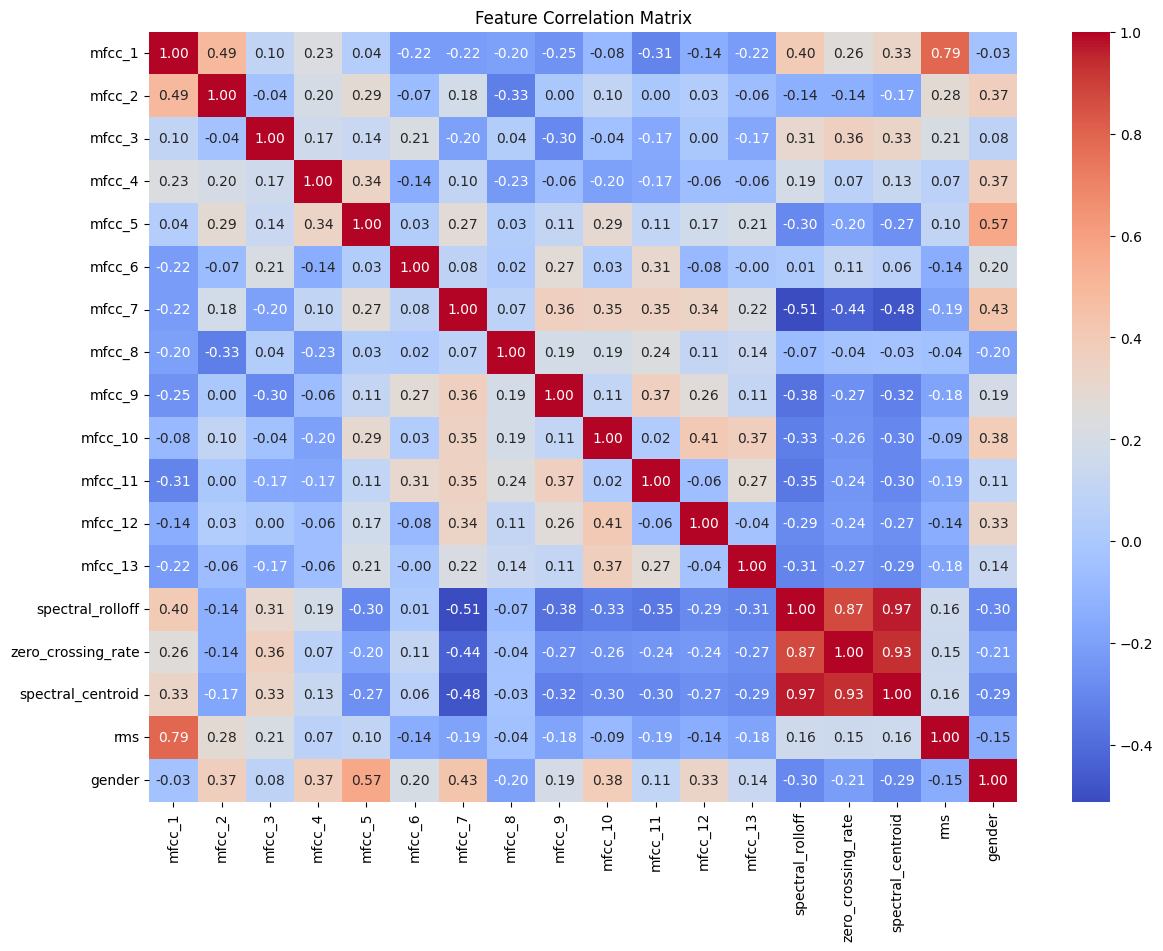

In [63]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [64]:
df = df.drop(['rms', 'spectral_centroid', 'zero_crossing_rate'], axis=1)

In [66]:
df.shape

(13393, 15)

# Splitting Data

In [67]:
X = df.drop(columns='gender')
y = df['gender']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 10714
Testing set size: 2679


In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Evaluation

## LogesticRegression

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       902
           1       0.94      0.95      0.95      1777

    accuracy                           0.93      2679
   macro avg       0.92      0.92      0.92      2679
weighted avg       0.93      0.93      0.93      2679

Confusion Matrix:


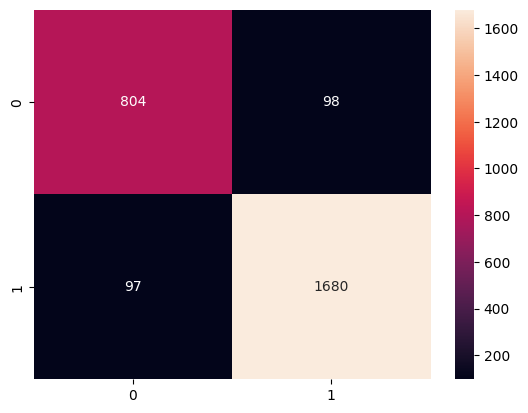

In [75]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_lr),annot=True,fmt='d')
plt.show()

## RandomForest

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       902
           1       0.96      0.97      0.97      1777

    accuracy                           0.96      2679
   macro avg       0.95      0.95      0.95      2679
weighted avg       0.96      0.96      0.96      2679

Confusion Matrix:


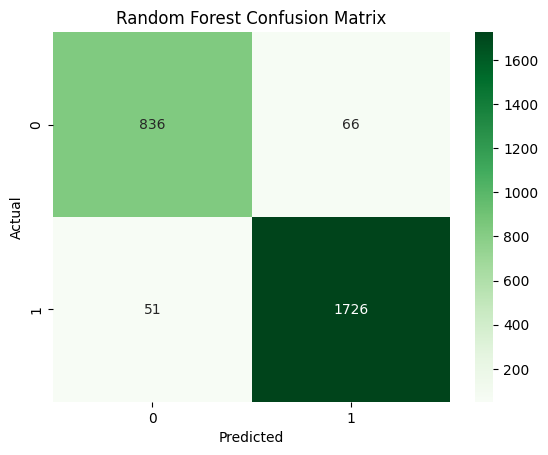

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


## XGBOOST

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       902
           1       0.98      0.97      0.97      1777

    accuracy                           0.96      2679
   macro avg       0.96      0.96      0.96      2679
weighted avg       0.96      0.96      0.96      2679

Confusion Matrix:


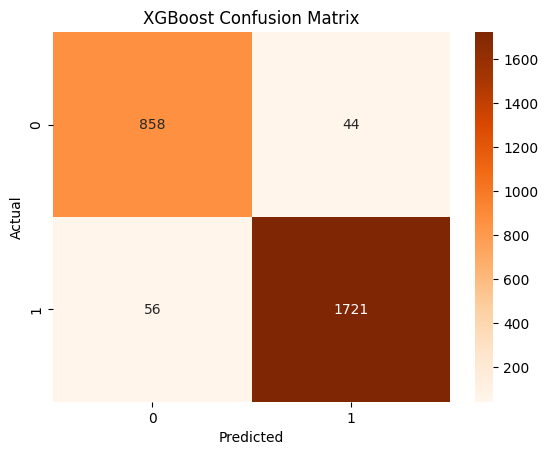

In [78]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost - Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()


## NaiveBayes

GaussianNB - Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       902
           1       0.93      0.91      0.92      1777

    accuracy                           0.89      2679
   macro avg       0.88      0.88      0.88      2679
weighted avg       0.89      0.89      0.89      2679

Confusion Matrix:


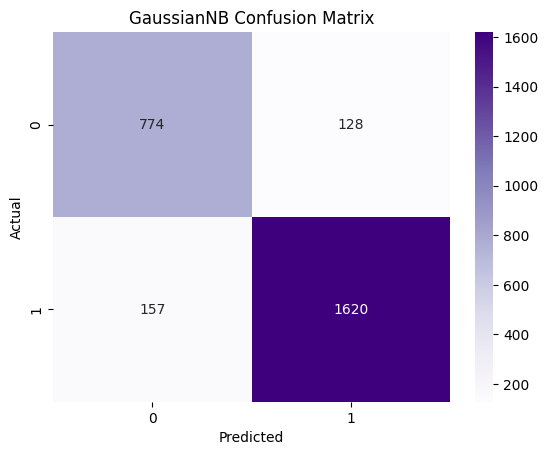

In [76]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

print("GaussianNB - Classification Report:")
print(classification_report(y_test, y_pred_gnb))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_gnb), annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GaussianNB Confusion Matrix')
plt.show()
